In [4]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import cv2 
from PIL import Image 

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.visualization_utils import plot_all_augmentations 

PROCESSED_DATA_PATH = '../data/processed/'
RAW_DATA_PATH = '../data/raw/'
IMAGE_ROOT_DIR = os.path.join(RAW_DATA_PATH, 'color')


df_splitted_path = os.path.join(PROCESSED_DATA_PATH, 'dataframe_splitted.csv')
if not os.path.exists(df_splitted_path):
    raise FileNotFoundError(f"Error: El archivo '{df_splitted_path}' no se encontró.")

df_splitted = pd.read_csv(df_splitted_path)
train_df = df_splitted[df_splitted['split'] == 'train'].reset_index(drop=True)
class_labels = sorted(df_splitted['class'].unique())
print(f"DataFrame de entrenamiento cargado con {len(train_df)} imágenes.")


DataFrame de entrenamiento cargado con 38013 imágenes.


### DEFINICIÓN DE ESTRATEGIAS DE AUMENTACIÓN


--- Visualizando Original, Aumentación Conservadora e Intensiva para 5 muestras: ---


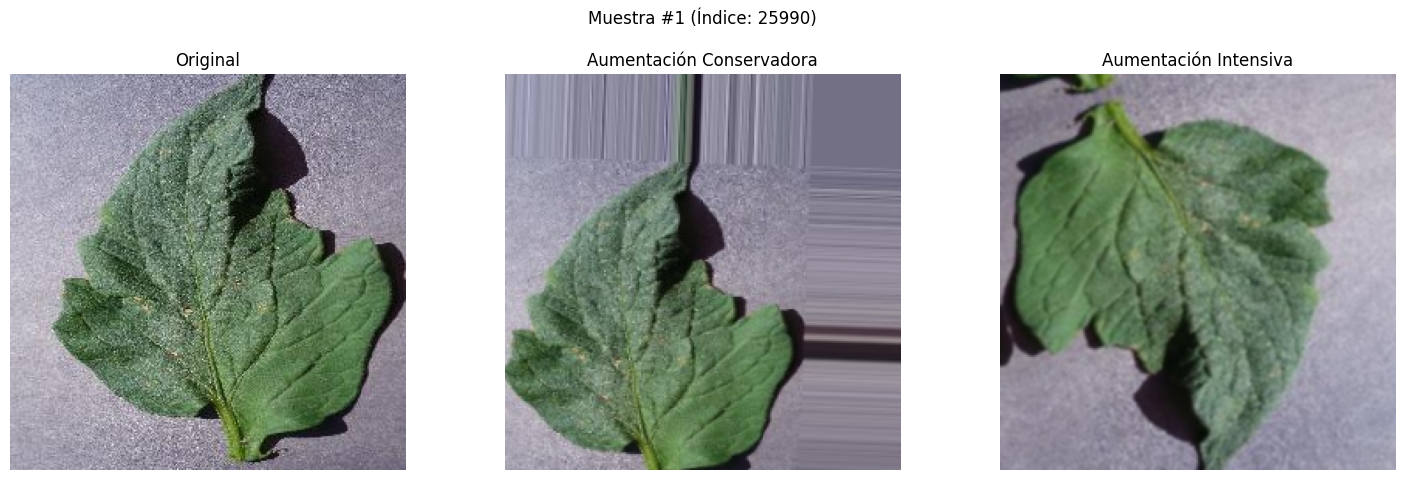

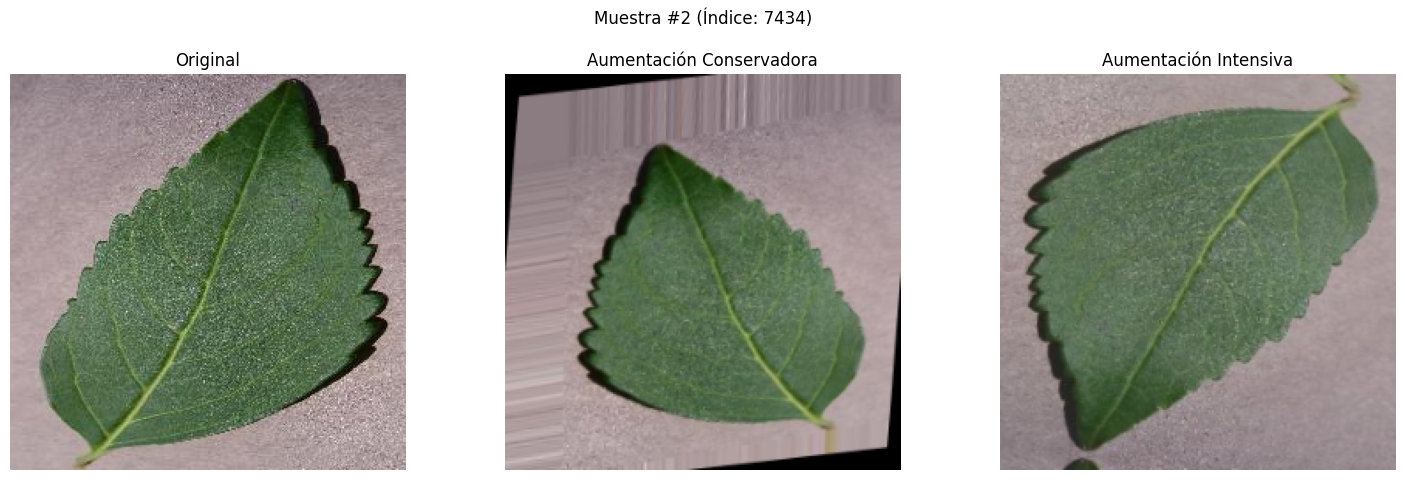

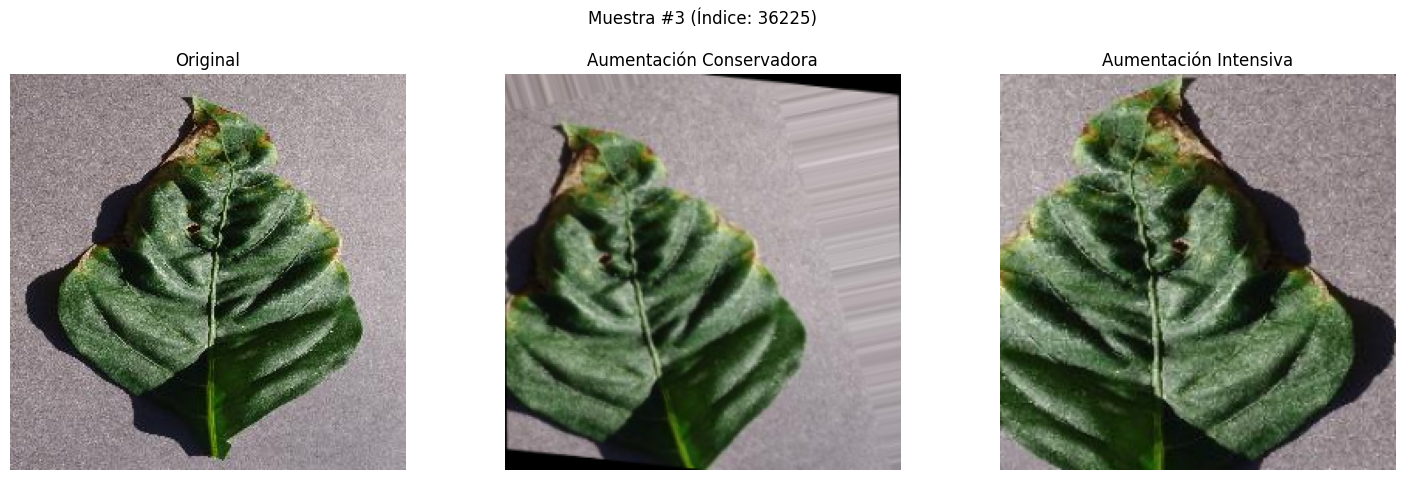

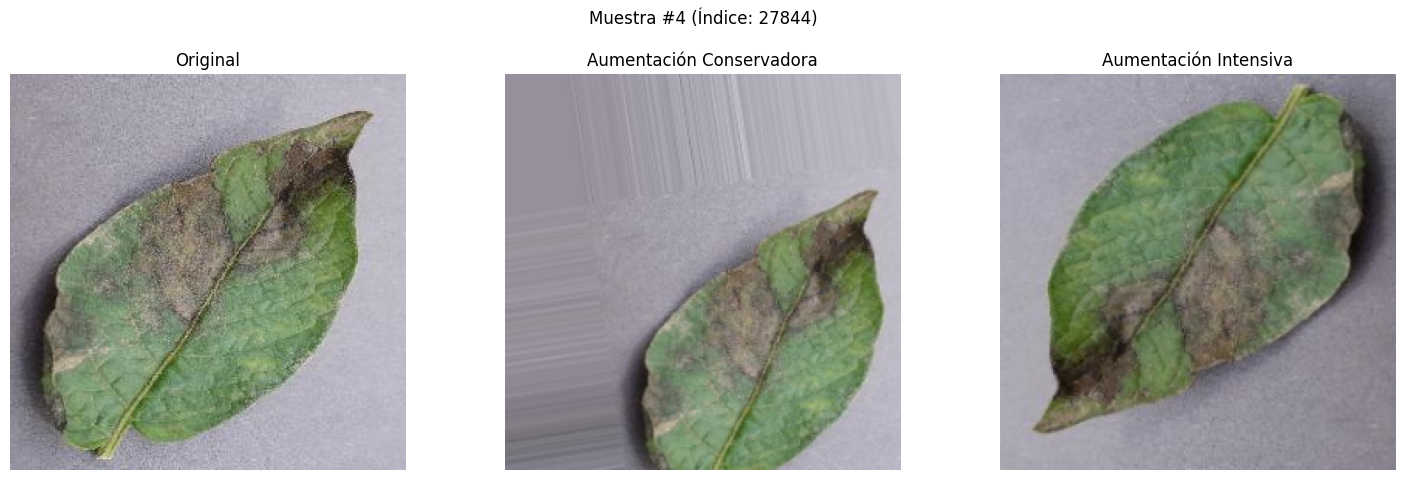

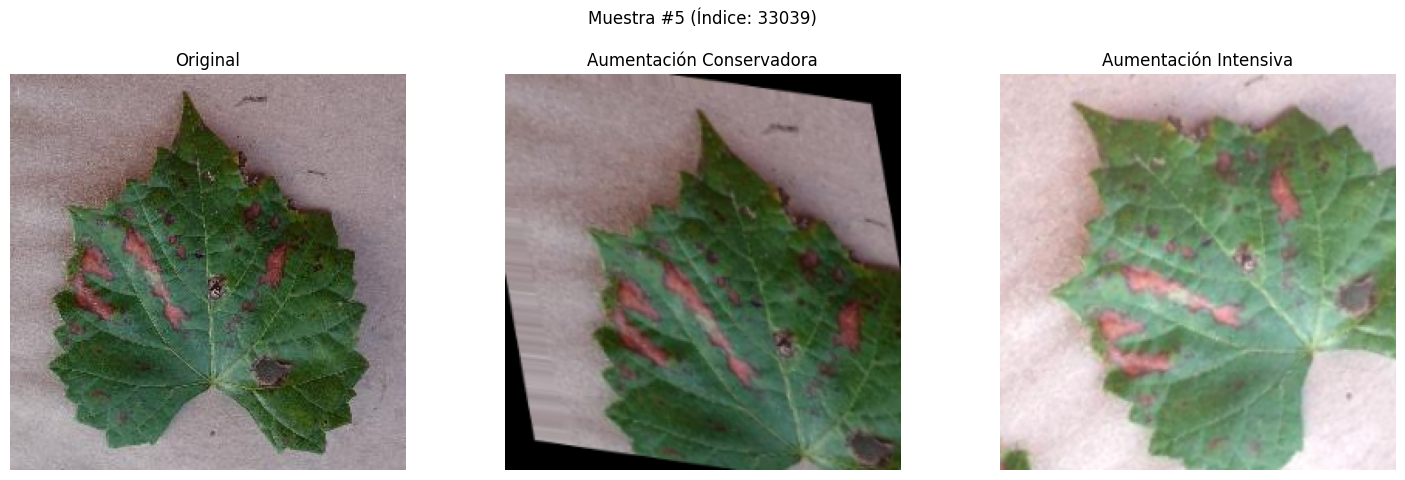

In [7]:
# Estrategia A: "Sin Color" (Geométrica)
transform_geometric_only = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.2, rotate_limit=25, border_mode=cv2.BORDER_REPLICATE, p=0.75),
    A.Affine(shear={'x': (-12, 12), 'y': (-12, 12)}, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Resize(224, 224, always_apply=True)
])

# Estrategia B: "Con Color" (Geométrica + Color)
transform_geometric_and_color = A.Compose([
    A.Rotate(limit=180, p=0.5),
    A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
    A.RandomScale(scale_limit=0.1, p=0.3),
    A.RandomCrop(width=200, height=200, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.Resize(224, 224, always_apply=True),
])

# --- 1. Importa tu función mejorada desde el módulo src ---
from src.visualization_utils import plot_all_augmentations

# --- 2. Define las funciones auxiliares que le pasarás como argumento ---
def load_image_np(filepath):
    """Carga una imagen y la devuelve como array NumPy."""
    # Importamos Image aquí para que la función sea autocontenida
    from PIL import Image 
    img_pil = Image.open(filepath).convert("RGB")
    return np.array(img_pil)

def apply_transformation_direct(original_image_array: np.ndarray, transformation_pipeline: A.Compose) -> np.ndarray:
    """Aplica una transformación de Albumentations directamente a una imagen NumPy."""
    transformed = transformation_pipeline(image=original_image_array)
    return transformed['image']


# --- 3. Llama a la función, pasándole todo lo que necesita ---
# (Asegúrate de que train_df, IMAGE_ROOT_DIR, etc., ya estén definidos en celdas anteriores)
plot_all_augmentations(
    dataframe=train_df,
    image_root_dir=IMAGE_ROOT_DIR,
    transform_conservative_pipeline=transform_geometric_only,
    transform_intensive_pipeline=transform_geometric_and_color,
    load_image_fn=load_image_np,
    apply_transform_fn=apply_transformation_direct,
    num_samples=5
)



Creando DataFrame de entrenamiento balanceado...
DataFrame balanceado creado con 146452 muestras.


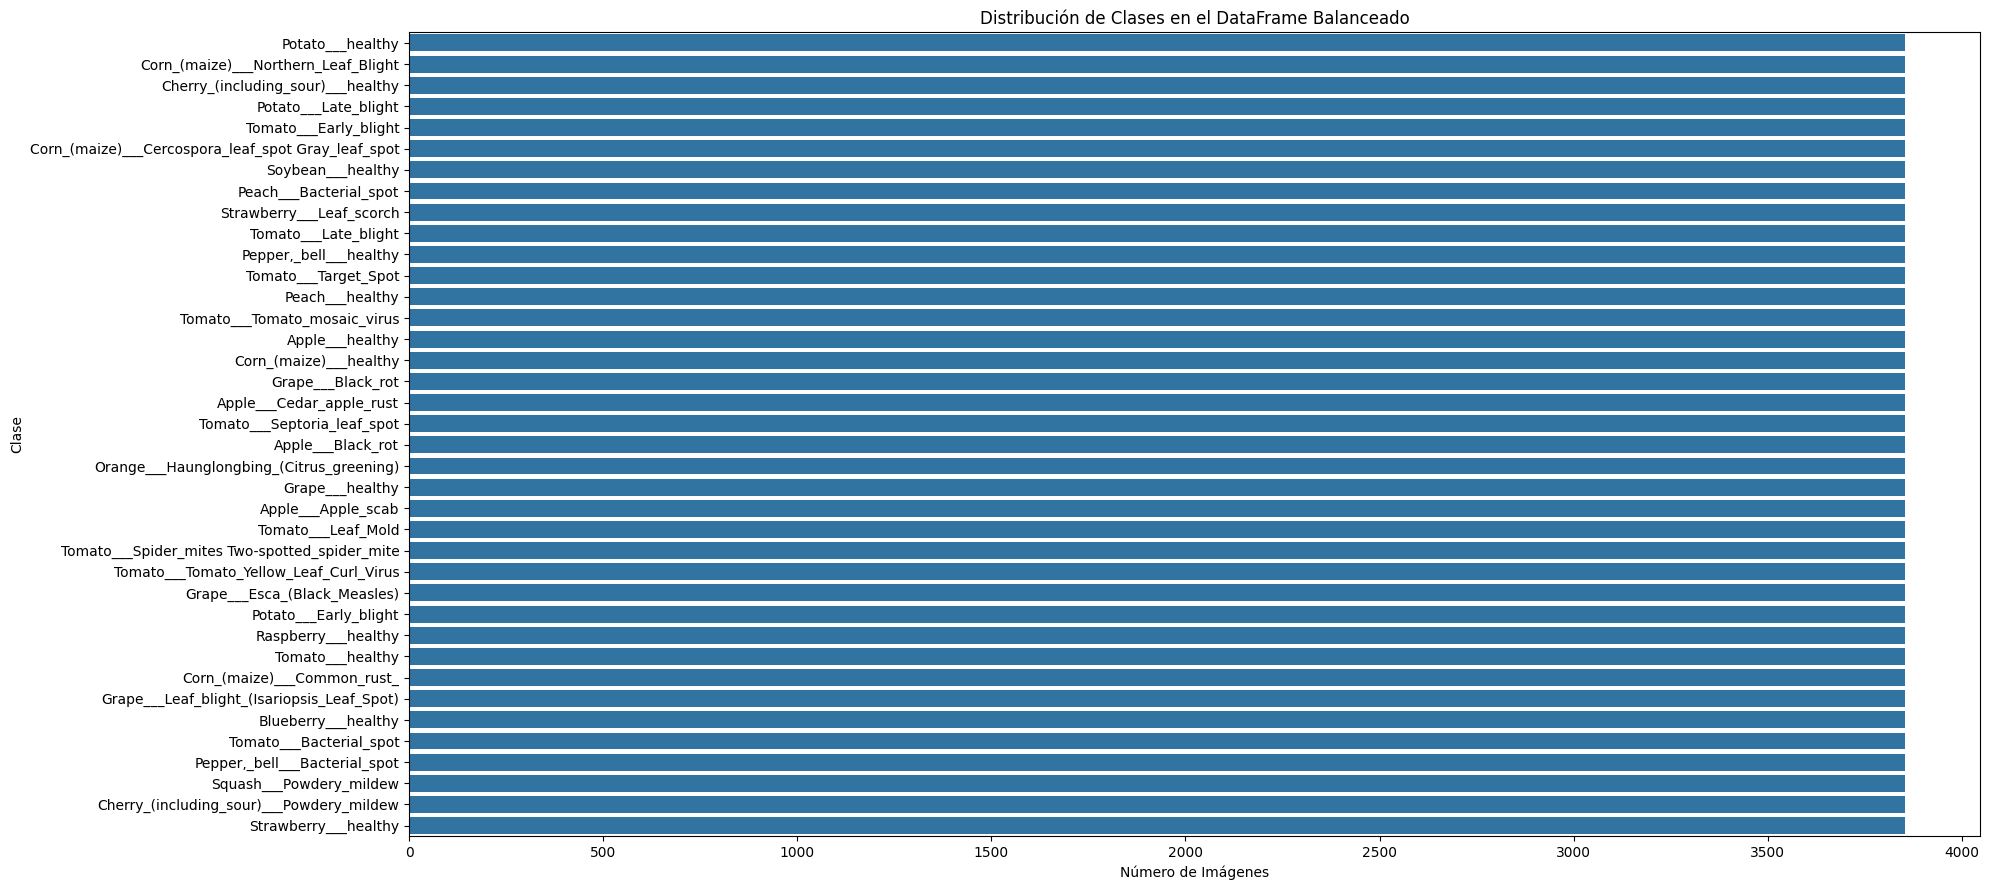

In [ ]:
import seaborn as sns

max_samples = train_df['class'].value_counts().max()
balanced_train_df = pd.concat([
    train_df[train_df['class'] == c].sample(n=max_samples, replace=True, random_state=42)
    for c in class_labels
]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"DataFrame balanceado creado con {len(balanced_train_df)} muestras.")

# --- Verificación Gráfica del Balanceo ---
plt.figure(figsize=(20, 9))
sns.countplot(data=balanced_train_df, y='class', order=balanced_train_df['class'].value_counts().index)
plt.title('Distribución de Clases en el DataFrame Balanceado')
plt.xlabel('Número de Imágenes')
plt.ylabel('Clase')
plt.tight_layout()
plt.show()

In [9]:
output_path = os.path.join(PROCESSED_DATA_PATH, 'df_train_balanced.csv')
balanced_train_df.to_csv(output_path, index=False)

print(f"\n¡ÉXITO! El notebook ha finalizado.")
print(f"El DataFrame de entrenamiento balanceado ha sido guardado en:")
print(output_path)
print("Ya puedes pasar al notebook de entrenamiento.")


¡ÉXITO! El notebook ha finalizado.
El DataFrame de entrenamiento balanceado ha sido guardado en:
../data/processed/df_train_balanced.csv
Ya puedes pasar al notebook de entrenamiento.
